# Nowcasting - Monthly

## Packages and Setting

In [1]:
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import itertools
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet, Ridge, Lasso, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import asgl

from functools import reduce
from NowcastingPipelineM import NowcastingPH_M
import dynamicfactoranalysis as dfa

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

warnings.filterwarnings("ignore")

import multiprocessing
processes = int(multiprocessing.cpu_count() * 2/3)

## ML x DFM

In [2]:
class NowcastingMLxDFM(NowcastingPH_M):
    def extend_data(self, df, vintage, DFM_order, optimize_order=False, **kwargs):
        factor_order, error_order, k_factors, factor_lag = DFM_order

        if optimize_order:
            model = dfa.DynamicFactorModelOptimizer(
                endog=df, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
                error_order_max=error_order, verbose=True,**kwargs).fit(**kwargs)
        else:
            model = dfa.DynamicFactorModel(
                endog=df, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
                error_order=error_order, **kwargs)
        
        results = model.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
        
        df_extended = pd.DataFrame()
        for col in df.columns:
            col_extended = pd.concat([df[[col]].dropna(), 
                                    results.predict(start=df[col].dropna().index[-1], end=vintage + pd.offsets.YearEnd(0))[[col]].iloc[1:]])
            df_extended = pd.concat([df_extended, col_extended], axis=1)
        df_extended.index.name = df.index.name

        return df_extended

    def load_econ_m(self, vintage, freq='M', extend=False, **kwargs):
        econ_m = super().load_econ_m(vintage, freq='M', **kwargs)
        econ_m = self.extend_data(econ_m, vintage, **kwargs) if extend else econ_m
        econ_m.index = pd.PeriodIndex(econ_m.index, freq=freq)
        return econ_m
    
    # def load_econ_q(self, vintage, freq='Q', extend=False, **kwargs):
    #     econ_q = super().load_econ_q(vintage, freq='Q', **kwargs)
    #     econ_q = self.extend_data(econ_q, vintage, **kwargs) if extend else econ_q
    #     econ_q.index = pd.PeriodIndex(econ_q.index, freq=freq)
    #     return econ_q
    
    def load_tweets(self, vintage, window, kmpair, freq='M', extend=False, **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)

        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        # tweets = super().load_tweets(vintage, freq='M', **kwargs)
        
        tweets = self.extend_data(tweets, vintage, **kwargs) if extend else tweets
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        
        return tweets
    
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df

    def fit_model(self, vintage, window, lag_order, DFM_order, optimize_order=False, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df_train, _, _ = self.load_data(vintage, window=1000, scaled=False, **kwargs)
        df_train = self.lag_data(df_train, lag_order).dropna()
        ###
        df_train = df_train.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,] ## Cut history to window size
        df_train = df_train.loc[df_train.index.month % 3 == vintage.month % 3, :] ## Cut to only M1/2/3 rows
        
        df_train = df_train.loc[: vintage - relativedelta(months=1), :].dropna() ## Get all data until prev month as train, and drop any incomplete rows
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        ###

        df, _, _ = self.load_data(vintage, window=window, scaled=False, extend=True, DFM_order=DFM_order, optimize_order=optimize_order, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,] ## Cut history to window size
        df = df.loc[df.index.month % 3 == vintage.month % 3, :] ## Cut to only M1/2/3 rows
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna() ## Get all months in the vintage year as test
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        self.prefix = f'ENet{lag_order} x ' + ('DFM_Opt' if optimize_order else f'DFM{DFM_order}')   # Override class name
        
        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        model_desc = f'ENet{lag_order} x ' + ('DFM_Opt' if optimize_order else f'DFM{DFM_order}')

        return nowcasts, model_desc

In [10]:
target = 'GDP'
kmpair = {'PE': ['CR_G0', 'CR_B0']}
vintage = pd.to_datetime('2017-12-31')
window = 13
# lag_order = target_lag, tweet_lag, econ_lag 
# DFM_order = factor_order, error_order, k_factors, factor_lag
model = NowcastingMLxDFM(target=target, lag_order=(4,0,0), DFM_order=(1,0,1,0), optimize_order=False, kmpair=kmpair)
df = model.load_data(vintage=vintage, window=1000, kmpair=kmpair, with_econ=False, with_tweets=True, extend=False, DFM_order=(1,0,1,0))[0]
display(df.tail(13))
# model.fit_model(vintage=vintage, window=window, kmpair=kmpair, with_econ=True, with_tweets=False, DFM_order=(1,0,1,0), lag_order=(0,0,0))
df = model.lag_data(df, lag_order=(4,0,0)).dropna()
display(df.tail(13))
df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,] ## Cut history to window size
df = df.loc[df.index.month % 3 == vintage.month % 3, :] ## Cut to only M1/2/3 rows
df

,target,TWT.CR_G0_PE,TWT.CR_B0_PE
date,,,
2016-12,0.376131,0.975562,0.900773
2017-01,-0.058676,1.020618,0.315021
2017-02,-0.058676,0.972071,2.046365
2017-03,-0.058676,0.459800,0.143587
2017-04,0.589173,0.326418,-0.330959
2017-05,0.589173,0.812719,0.496891
2017-06,0.589173,0.409436,0.387182
2017-07,0.875188,-0.239533,-0.431951
2017-08,0.875188,0.515711,0.518164


,target,TWT.CR_G0_PE,TWT.CR_B0_PE,target.Q1,target.Q2,target.Q3,target.Q4
date,,,,,,,
2016-09,0.712375,0.385402,4.031747,0.800894,0.380616,0.482729,0.113393
2016-10,0.376131,3.050986,5.312312,0.712375,0.800894,0.380616,0.482729
2016-11,0.376131,2.200609,1.843276,0.712375,0.800894,0.380616,0.482729
2016-12,0.376131,0.975562,0.900773,0.712375,0.800894,0.380616,0.482729
2017-01,-0.058676,1.020618,0.315021,0.376131,0.712375,0.800894,0.380616
2017-02,-0.058676,0.972071,2.046365,0.376131,0.712375,0.800894,0.380616
2017-03,-0.058676,0.459800,0.143587,0.376131,0.712375,0.800894,0.380616
2017-04,0.589173,0.326418,-0.330959,-0.058676,0.376131,0.712375,0.800894
2017-05,0.589173,0.812719,0.496891,-0.058676,0.376131,0.712375,0.800894


,target,TWT.CR_G0_PE,TWT.CR_B0_PE,target.Q1,target.Q2,target.Q3,target.Q4
date,,,,,,,
2016-12,0.376131,0.975562,0.900773,0.712375,0.800894,0.380616,0.482729
2017-03,-0.058676,0.459800,0.143587,0.376131,0.712375,0.800894,0.380616
2017-06,0.589173,0.409436,0.387182,-0.058676,0.376131,0.712375,0.800894
2017-09,0.875188,0.726733,1.580433,0.589173,-0.058676,0.376131,0.712375


Running NowcastingMLxDFM
Vintage: 2017-01-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-02-28 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-03-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-04-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-05-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-06-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-07-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-08-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-09-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-10-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-11-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2017-12-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-01-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-02-28 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-03-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-04-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-05-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-06-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-07-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-08-31 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 2018-09-30 	 ENet(4, 1, 1) x DFM_Opt
Vintage: 

,date,Model,Nowcast_A,Actual_A,Difference_A,Overall_RMSE_A,Month_RMSE_A,Quarter_RMSE_A,Year_RMSE_A,Period_RMSE_A,...,Actual_Q,Difference_Q,Overall_RMSE_Q,Month_RMSE_Q,Quarter_RMSE_Q,Period_RMSE_Q,ForecastQ1,ForecastQ2,ForecastQ3,ForecastQ4
0,2017-01-31,"ENet(4, 1, 1) x DFM_Opt",NaN,6.930988,NaN,0.674003,NaN,NaN,0.156394,0.123210,...,6.374133,NaN,7.689253,NaN,0.864502,0.683892,NaN,NaN,NaN,NaN
1,2017-02-28,"ENet(4, 1, 1) x DFM_Opt",NaN,6.930988,NaN,0.674003,NaN,0.419209,0.156394,0.123210,...,6.374133,1.027513,7.689253,2.510909,0.864502,0.683892,7.401646,NaN,NaN,NaN
2,2017-03-31,"ENet(4, 1, 1) x DFM_Opt",NaN,6.930988,NaN,0.674003,NaN,0.856052,0.156394,0.123210,...,6.374133,0.662528,7.689253,10.471296,0.864502,0.683892,7.036661,NaN,NaN,NaN
3,2017-04-30,"ENet(4, 1, 1) x DFM_Opt",NaN,6.930988,NaN,0.674003,NaN,NaN,0.156394,0.123210,...,7.177099,NaN,7.689253,NaN,0.653208,0.683892,7.178316,NaN,NaN,NaN
4,2017-05-31,"ENet(4, 1, 1) x DFM_Opt",NaN,6.930988,NaN,0.674003,NaN,0.419209,0.156394,0.123210,...,7.177099,-0.569275,7.689253,2.510909,0.653208,0.683892,6.440889,6.607824,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-08-31,"ENet(4, 1, 1) x DFM_Opt",NaN,7.599235,NaN,0.674003,NaN,0.419209,1.066443,0.945188,...,7.635937,-2.581403,7.689253,2.510909,3.759984,11.232145,8.009862,7.311710,5.054535,NaN
68,2022-09-30,"ENet(4, 1, 1) x DFM_Opt",NaN,7.599235,NaN,0.674003,NaN,0.856052,1.066443,0.945188,...,7.635937,-4.648798,7.689253,10.471296,3.759984,11.232145,8.097495,7.383024,2.987140,NaN
69,2022-10-31,"ENet(4, 1, 1) x DFM_Opt",NaN,7.599235,NaN,0.674003,NaN,NaN,1.066443,0.945188,...,7.225544,NaN,7.689253,NaN,3.800782,11.232145,8.087769,7.492543,3.723523,NaN
70,2022-11-30,"ENet(4, 1, 1) x DFM_Opt",6.61612,7.599235,-0.983115,0.674003,0.419209,0.419209,1.066443,0.945188,...,7.225544,-3.503805,7.689253,2.510909,3.800782,11.232145,7.974645,7.415078,7.629158,3.721739


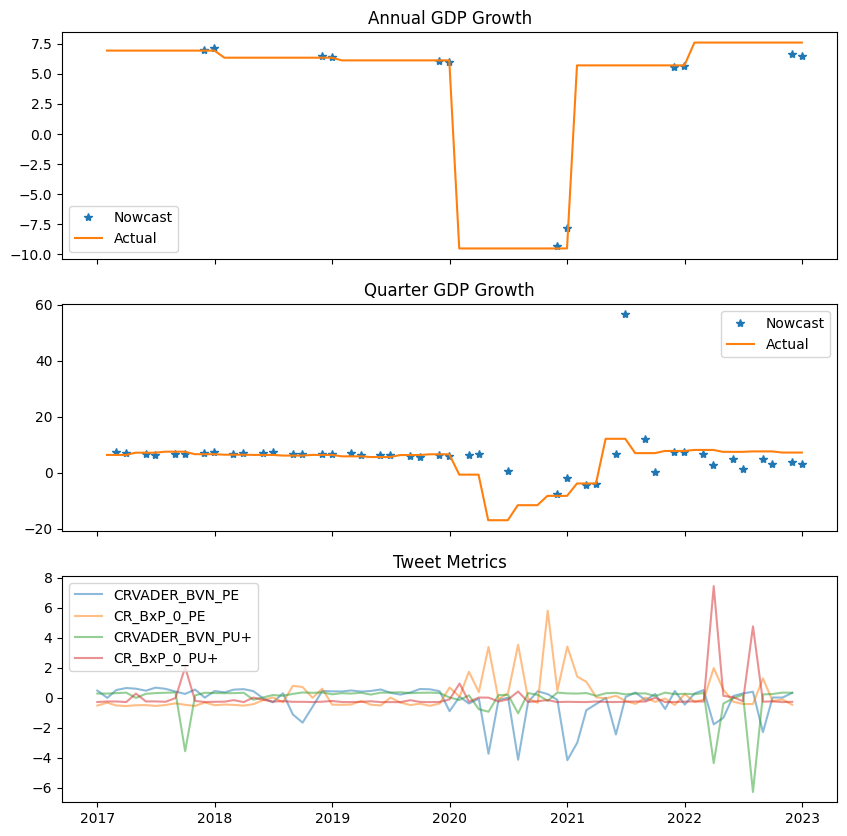

In [12]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 25
model = NowcastingMLxDFM(lag_order=(4,1,1), DFM_order=(3,3,3,0), optimize_order=True, kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=True, with_tweets=True)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## DFM-MQ

In [31]:
class NowcastingDFM(NowcastingPH_M):
    def fit_model(self, vintage, window, DFM_order, **kwargs):
        df, target_scaler, econ_scaler = self.load_data(vintage, window=window, scaled=False, **kwargs)
        k_factors, global_factor_order, local_factor_order = DFM_order
        
        endog_m = df.loc[:, df.columns.drop('target')]
        endog_q = df.loc[df.index.month % 3 == 0,'target':'target']
        endog_q.index = pd.PeriodIndex(endog_q.index, freq='Q')
        
        ## Specify number of global factors (int), or factors per observed variable (dict)
        # factors = 1
        # factor_multiplicities = k_factors
        # factor_orders = 1

        factors = dict()
        for col in list(endog_m.columns):
            if col[0:3] == 'TWT':
                factors[col] = ['Global','Tweets']
            elif col[0:3] == 'ECN':
                factors[col] = ['Global','Econ']
        factors['target'] = ['Global'] # ['Global','Econ'] if kwargs.get('with_econ', True) else ['Global']
        factor_multiplicities = {'Global': k_factors}
        factor_orders = {'Global': global_factor_order}
        if kwargs.get('with_econ', True): factor_orders['Econ'] = local_factor_order
        if kwargs.get('with_tweets', True): factor_orders['Tweets'] = local_factor_order
        
        model = sm.tsa.DynamicFactorMQ(endog_m, endog_quarterly=endog_q, factors=factors, factor_orders=factor_orders, factor_multiplicities=factor_multiplicities)
        self.prefix = f'DFM{DFM_order}'    # Override class name

        nowcasts = list(model.fit().predict(start=f'{vintage.year}-01', end=f'{vintage.year}-12').resample('Q').last()['target'])
        model_desc = f'DFM{DFM_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         # tweets[col] = tweets[col].diff()
        #         tweets[col] = tweets[col].clip(lower=1)
        #         tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        # tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

Running NowcastingDFM
Vintage: 2017-01-31 	 DFM(1, 1, 1)
Vintage: 2017-02-28 	 DFM(1, 1, 1)
Vintage: 2017-03-31 	 DFM(1, 1, 1)
Vintage: 2017-04-30 	 DFM(1, 1, 1)
Vintage: 2017-05-31 	 DFM(1, 1, 1)
Vintage: 2017-06-30 	 DFM(1, 1, 1)
Vintage: 2017-07-31 	 DFM(1, 1, 1)
Vintage: 2017-08-31 	 DFM(1, 1, 1)
Vintage: 2017-09-30 	 DFM(1, 1, 1)
Vintage: 2017-10-31 	 DFM(1, 1, 1)
Vintage: 2017-11-30 	 DFM(1, 1, 1)
Vintage: 2017-12-31 	 DFM(1, 1, 1)
Vintage: 2018-01-31 	 DFM(1, 1, 1)
Vintage: 2018-02-28 	 DFM(1, 1, 1)
Vintage: 2018-03-31 	 DFM(1, 1, 1)
Vintage: 2018-04-30 	 DFM(1, 1, 1)
Vintage: 2018-05-31 	 DFM(1, 1, 1)
Vintage: 2018-06-30 	 DFM(1, 1, 1)
Vintage: 2018-07-31 	 DFM(1, 1, 1)
Vintage: 2018-08-31 	 DFM(1, 1, 1)
Vintage: 2018-09-30 	 DFM(1, 1, 1)
Vintage: 2018-10-31 	 DFM(1, 1, 1)
Vintage: 2018-11-30 	 DFM(1, 1, 1)
Vintage: 2018-12-31 	 DFM(1, 1, 1)
Vintage: 2019-01-31 	 DFM(1, 1, 1)
Vintage: 2019-02-28 	 DFM(1, 1, 1)
Vintage: 2019-03-31 	 DFM(1, 1, 1)
Vintage: 2019-04-30 	 DFM(1, 1, 1

,date,Model,Nowcast_A,Actual_A,Difference_A,Overall_RMSE_A,Month_RMSE_A,Quarter_RMSE_A,Year_RMSE_A,Period_RMSE_A,...,Actual_Q,Difference_Q,Overall_RMSE_Q,Month_RMSE_Q,Quarter_RMSE_Q,Period_RMSE_Q,ForecastQ1,ForecastQ2,ForecastQ3,ForecastQ4
0,2017-01-31,"DFM(1, 1, 1)",NaN,6.930988,NaN,4.384136,NaN,4.841963,0.268991,0.313836,...,6.374133,0.654144,5.832949,6.693091,0.531831,0.547822,7.028277,6.987571,6.951712,6.926024
1,2017-02-28,"DFM(1, 1, 1)",6.850922,6.930988,-0.080066,4.384136,6.949211,4.226847,0.268991,0.313836,...,6.374133,0.458761,5.832949,5.351311,0.531831,0.547822,6.832894,6.846671,6.858305,6.863867
2,2017-03-31,"DFM(1, 1, 1)",6.851356,6.930988,-0.079632,4.384136,6.911497,4.172182,0.268991,0.313836,...,6.374133,0.458440,5.832949,5.351252,0.531831,0.547822,6.832572,6.848571,6.858512,6.863752
3,2017-04-30,"DFM(1, 1, 1)",6.851423,6.930988,-0.079565,4.384136,6.923816,4.841963,0.268991,0.313836,...,7.177099,-0.328240,5.832949,6.693091,0.710712,0.547822,6.832491,6.848859,6.858588,6.863727
4,2017-05-31,"DFM(1, 1, 1)",6.464828,6.930988,-0.466160,4.384136,4.020648,4.226847,0.268991,0.313836,...,7.177099,-0.838967,5.832949,5.351311,0.710712,0.547822,6.867615,6.338132,6.506557,6.626173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-08-31,"DFM(1, 1, 1)",10.025767,7.599235,2.426531,4.384136,2.441655,4.226847,1.586560,6.192157,...,7.635937,10.729040,5.832949,5.351311,10.526807,8.230825,9.581960,5.337730,18.364977,6.744854
68,2022-09-30,"DFM(1, 1, 1)",9.439516,7.599235,1.840280,4.384136,2.133155,4.172182,1.586560,6.192157,...,7.635937,10.767610,5.832949,5.351252,10.526807,8.230825,9.609166,5.380172,18.403547,4.622648
69,2022-10-31,"DFM(1, 1, 1)",9.736747,7.599235,2.137512,4.384136,2.205947,4.841963,1.586560,6.192157,...,7.225544,-1.512574,5.832949,6.693091,5.782193,8.230825,9.554760,5.371237,18.367120,5.712970
70,2022-11-30,"DFM(1, 1, 1)",5.651927,7.599235,-1.947309,4.384136,1.022798,4.226847,1.586560,6.192157,...,7.225544,-6.940172,5.832949,5.351311,5.782193,8.230825,9.286055,5.515683,16.910667,0.285372


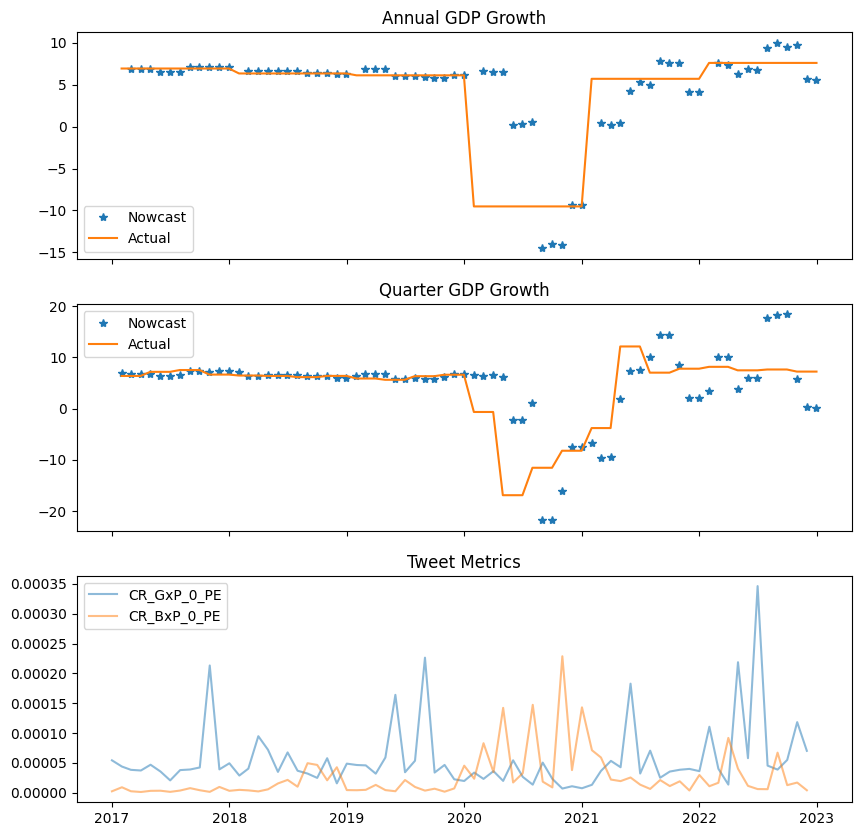

In [36]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CR_GxP_0','CR_BxP_0']}
window = 1000
model = NowcastingDFM(DFM_order=(1,1,1), kmpair=kmpair, target=target) # DFM_order = k_factors, global_factor_order, local_factor_order
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True) #start=pd.to_datetime('2022-10-31'),end=pd.to_datetime('2022-12-31')
# summary = pd.read_csv('Results/DFM(2, 1, 1)-M_W25_GDP_T_summary.csv', parse_dates=['date'])
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

In [253]:
target = 'GDP'
# kmpair = {'PE': ['C_BxP_0'],'PU+': ['C_BxP_0']}
# kmpair = {'PE': ['C_GxP_0', 'C_BxP_0'],'PU+': ['C_GxP_0','C_BxP_0']}
kmpair = {}
window = 25
vintage = pd.to_datetime('2017-01-31')
model = NowcastingDFM(kmpair=kmpair, target=target)
df = model.load_data(vintage=vintage, window=window, kmpair=kmpair, with_econ=True, with_tweets=False, scaled=False)[0]

endog_m = df.loc[:, df.columns.drop('target')]
endog_q = df.loc[df.index.month % 3 == 0,'target':'target']
endog_q.index = pd.PeriodIndex(endog_q.index, freq='Q')

In [264]:
## Specify number of global factors (int), or factors per observed variable (dict)
# factors = 1
# factor_multiplicities = 2
# factor_orders = 4

factors = dict()
for col in list(endog_m.columns):
    if col[0:3] == 'TWT':
        factors[col] = ['Global','Tweets']
    elif col[0:3] == 'ECN':
        factors[col] = ['Global','Econ']
factors['target'] = ['Global']
factor_multiplicities = {'Global': 2}
# factor_orders = {'Global': 4,'Econ': 1, 'Tweets': 1}
factor_orders = {'Global':4}

model = sm.tsa.DynamicFactorMQ(endog_m, endog_quarterly=endog_q, factors=factors, factor_orders=factor_orders, factor_multiplicities=factor_multiplicities)
# model.summary()
point_forecasts_m = list(model.fit().predict(start='2017-01', end='2017-12').resample('Q').last()['target'])
point_forecasts_m

[7.600753732095051, 7.467281764074828, 7.060826859417706, 6.86615782948628]

In [162]:
## Specify number of global factors (int), or factors per observed variable (dict)
# factors = 2
# factor_multiplicities = 1
# factor_orders=1

factors = dict()
for col in list(endog_m.columns):
    if col[0:3] == 'TWT':
        factors[col] = ['Global','Tweets']
    elif col[0:3] == 'ECN':
        factors[col] = ['Global','Econ']
factors['target'] = ['Global','Econ']
factor_multiplicities = {'Global': 2}
factor_orders=1

model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                     13
                   + 4 factors in 3 blocks   # of quarterly variables:                    1
                   + Mixed frequency (M/Q)   # of factor blocks:                          3
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            2007-05   Standardize variables:                    True
                                 - 2017-01                                                 
              Observed variables / factor loadings              
================================================================
      Dep. variable   Global.1   Global.2       Econ      Tweets
----------------------------------------------------------------
 TWT.CRVADER_BVN_PE      X          X                       X   
    TWT.CR_BxP_0_PE      X          X                       X   
TWT.CRVADER_BVN_PU+      X          X                       X   
   TWT.CR_BxP_0_PU+      X          X                       X   
        ECN.IPI_YoY      X          X            X              
         ECN.m1_YoY      X          X            X              
     ECN.tdr_php360      X          X            X              
    ECN.tbill_usd90      X          X            X              
     ECN.phpusd_YoY      X          X            X              
    ECN.exports_YoY      X          X            X              
    ECN.imports_YoY      X          X            X              
    ECN.govtexp_YoY      X          X            X              
  ECN.pseiclose_YoY      X          X            X              
             target      X          X            X              
        Factor blocks:       
=============================
             block      order
-----------------------------
Global.1, Global.2          1
              Econ          1
            Tweets          1
=============================
"""

In [146]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Dynamic Factor Results                                   
=============================================================================================
Dep. Variable:     "TWT.CRVADER_BVN_PE", and 13 more   No. Observations:                  117
Model:                          Dynamic Factor Model   Log Likelihood               -1112.580
                             + 2 factors in 2 blocks   AIC                           2345.160
                             + Mixed frequency (M/Q)   BIC                           2510.890
                               + AR(1) idiosyncratic   HQIC                          2412.444
Date:                               Mon, 13 Nov 2023   EM Iterations                      279
Time:                                       17:42:26                                         
Sample:                                   05-31-2007                                         
                                        - 01-31-2017                                         
Covariance Type:                        Not computed                                         
                            Observation equation:                            
=============================================================================
   Factor loadings:          0          1    idiosyncratic: AR(1)        var.
-----------------------------------------------------------------------------
 TWT.CRVADER_BVN_PE      -0.26      -0.31                   -0.00        0.32
    TWT.CR_BxP_0_PE       0.14       0.33                    0.02        0.44
TWT.CRVADER_BVN_PU+      -0.20      -0.32                   -0.19        0.35
   TWT.CR_BxP_0_PU+       0.20       0.32                   -0.11        0.33
        ECN.IPI_YoY      -0.28       0.20                    0.56        0.33
         ECN.m1_YoY      -0.18       0.08                    0.61        0.47
     ECN.tdr_php360      -0.33       0.03                    0.96        0.04
    ECN.tbill_usd90       0.03       0.20                    0.87        0.27
     ECN.phpusd_YoY       0.35      -0.03                    0.92        0.09
    ECN.exports_YoY      -0.27       0.16                    0.45        0.38
    ECN.imports_YoY      -0.19       0.15                    0.50        0.60
    ECN.govtexp_YoY      -0.13      -0.04                    0.29        0.89
  ECN.pseiclose_YoY      -0.38       0.07                    0.76        0.14
             target      -0.01       0.04                    0.81        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.97              0.21
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.72              2.25
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [147]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:2]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by 0       Top ten variables explained by 1  \
                          Variable $R^2$                         Variable   
0                ECN.pseiclose_YoY  0.75                 TWT.CR_BxP_0_PU+   
1                   ECN.phpusd_YoY  0.57                  TWT.CR_BxP_0_PE   
2                   ECN.tdr_php360  0.49              TWT.CRVADER_BVN_PU+   
3                  ECN.exports_YoY  0.47               TWT.CRVADER_BVN_PE   
4                      ECN.IPI_YoY  0.39                  ECN.tbill_usd90   
5                           target  0.32                           target   
6                       ECN.m1_YoY  0.27                      ECN.IPI_YoY   
7               TWT.CRVADER_BVN_PE  0.17                  ECN.exports_YoY   
8                  ECN.imports_YoY  0.12                  ECN.imports_YoY   
9              TWT.CRVADER_BVN_PU+  0.08                       ECN.m1_YoY   

         
  $R^2$  
0  0.53  
1  0.52  
2  0.49  
3  0.43  
4  0.24  
5  0.23  
6  0.22  
7  0.14  
8  0.10  
9  0.05

## Elastic Net

In [41]:
class NowcastingML(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = ElasticNet()
        model.fit(X_train, y_train)
        self.prefix = f'ENet{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'ENet{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [38]:
target = 'GDP'
kmpair = {'PE':['C_00']}
window=37
vintage = pd.to_datetime('2017-05-31')
model = NowcastingML(lag_order=(0,0,0), kmpair  =kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
df = model.load_data(vintage,window=1000,kmpair=kmpair, save_aggregate=True, with_econ=False, with_tweets=True)[0]
df = model.lag_data(df, lag_order=(0,0,0))
df = df.loc[vintage - relativedelta(months=window) :,]
df = df.loc[df.index.month % 3 == vintage.month % 3, :]
display(df)
X_test = df.loc[vintage+ relativedelta(month=1) :, df.columns.drop('target')].dropna()
df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
df_train.index = df_train.index.to_timestamp()
X_test

# model.fit_model(vintage,window=37,lag_order=(1,0,0), with_tweets=True, kmpair=kmpair)

,target,TWT.C_00_PE
date,,
2014-05,0.439420,0.972535
2014-08,-0.357430,0.916339
2014-11,0.273207,0.827808
2015-02,-0.902989,1.494887
2015-05,0.011543,1.276009
2015-08,0.161638,0.317447
2015-11,0.525904,1.327834
2016-02,0.425193,0.492731
2016-05,0.839701,4.233882


,TWT.C_00_PE
date,
2017-02,1.033273
2017-05,0.888555


In [ ]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 25
model = NowcastingML(lag_order=(1,1,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## 3PRF

In [43]:
import numpy as np
from sklearn.linear_model import LinearRegression as LR
class TPRF():
    def __init__(self, **kwargs):
        self.kwargs = kwargs
    def autoproxy(self, X, y, n_proxy):
        """
        Use the autoproxy algorithm for calculating the proxies,
        given an array of predictors and corresponding target values

        :param X: Array of predictors
        :param y: Array of returns (target values)
        :param n_proxy: number of proxies to be calculated
        :return r0: Array of proxies
        """
        r0 = np.array(y)
        yhatt = 1
        for i in range(0, n_proxy - 1):
            (yhat, yhatt) = self.tprf(X, y, r0, False)
            r0 = np.hstack([y - yhat, r0])
        return r0
    def tprf(self, X, y, Z, oos_present, oos=[]):
        """
        Computes the returns (y) based on the set of predictors
        (X) and proxies (Z) using the three pass regression filter method

        :param X: Array of predictors (Shape: T x N, where
        T = number of timestamps in the training set,
        N = number of predictors)
        :param y: Array of returns (Shape: T x 1, where
        T = number of timestamps in the training set)
        :param Z: Array of proxies (Shape: T x L, where
        T = number of timestamps in the training set,
        L = number of proxies)
        :param oos_present: True if out of sample data is present (oos),
        False otherwise
        :param oos: Out of sample data (predictors)(Shape: 1 x N)
        :return yhat: Forecasted returns for in sample data (Shape: T x 1)
        :return yhatt: Forecasted return for out of sample array of predictors (float)
        """

        # Pass 1 (Dependent - Value of predictor i across given time intervals,
        # Independent - Set of proxies)

        phi = np.ndarray(shape=(X.shape[1], Z.shape[1]))
        eta = []
        for i in range(0, X.shape[1]):
            first_pass_model = LR()
            first_pass_model = first_pass_model.fit(X=Z, y=X[:, i])
            phi[i, :] = first_pass_model.coef_
            eta.append(first_pass_model.intercept_)

        # Pass 2 (Dependant - Cross section of predictor values at time t,
        # Independent - phi (from Pass 1)

        eta = np.array(eta).reshape(X.shape[1], 1)
        sigma = np.ndarray(shape=(X.shape[0], Z.shape[1]))
        eta1 = []
        for t in range(0, X.shape[0]):
            second_pass_model = LR()
            second_pass_model.fit(X=phi, y=X[t, :].T)
            sigma[t, :] = second_pass_model.coef_.flatten()
            eta1.append(second_pass_model.intercept_)

        eta1 = np.array(eta1)

        # Pass 3 (Dependant - Array of returns, Independent - sigma (from Pass 2)

        third_pass_model = LR()
        third_pass_model.fit(X=sigma, y=y)
        coeff, intercept = (third_pass_model.coef_, third_pass_model.intercept_)
        yhat = np.dot(sigma, coeff.T) + intercept

        # If out of sample set of predictors is present, compute the forecasted
        # return by running the second pass with out of sample predictors as the
        # dependant variable, and multiplying the resultant sigma with beta (coeff) from
        # the previous third pass and adding the intercept

        yhatt = np.nan
        if oos_present:
            second_pass_model = LR()
            second_pass_model.fit(X=phi, y=oos)
            sigma = second_pass_model.coef_.flatten()
            yhatt = np.dot(sigma, coeff.T) + intercept
        return yhat, yhatt
    def predict(self, X_train, y_train, X_test_, n_proxies=3, **kwargs):
        Z = self.autoproxy(X_train.to_numpy(), y_train.to_numpy().reshape(-1, 1), n_proxies)
        X_train = X_train.to_numpy()
        X_test_ = X_test_.to_numpy().flatten()
        X_train = (X_train.T/np.std(X_train, axis = 0).reshape(-1, 1)).T
        X_test_ = (X_test_.T/np.std(X_test_, axis = 0).reshape(-1, 1).flatten()).T
        yhat, yhatt = self.tprf(X_train, y_train, Z, True, X_test_)
        return yhatt

class Nowcasting3PRF(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = TPRF()
        # model.fit(X_train, y_train)
        self.prefix = f'TPRF{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_train, y_train, X_test_.to_frame().T) if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'TPRF{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].clip(lower=1)
        #         tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [ ]:
target = 'GDP'
# kmpair={}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = Nowcasting3PRF(lag_order=(1,1,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=1)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## Adaptive Lasso

In [47]:
class NowcastingALAS(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        weights = asgl.WEIGHTS(penalization='alasso', weight_technique='pca_pct', lasso_power_weight=[1.2],
                gl_power_weight=[1.2], variability_pct=0.9)
        lasso_weights, gl_weights = weights.fit(x=X_train.to_numpy(), y=y_train.to_numpy())
        model = asgl.ASGL(model='lm', penalization='alasso', lambda1 = [0.1], lasso_weights = lasso_weights, intercept=True)
        model.fit(x=X_train.to_numpy(),y=y_train.to_numpy())
        self.prefix = f'ALAS{lag_order}'    # Override class name

        nowcasts = [(model.predict(x_new=X_test_.to_frame().T.to_numpy()) if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = [(target_scaler.inverse_transform(nowcast).flatten().item() if not np.isnan(nowcast) else np.nan) for nowcast in nowcasts]
        model_desc = f'ALAS{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
                # tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [13]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window=1000
vintage = pd.to_datetime('2020-11-30')
model = NowcastingALAS(lag_order=(1,3,0), kmpair =kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
# model.fit_model(vintage=vintage, window=window,lag_order=(0,0,0),kmpair=kmpair, with_econ=False, with_tweets=True)
# summary = model.run(window=window, save_aggregate=True, with_econ=False, with_tweets=True)
df, target_scaler, econ_scaler = model.load_data(vintage,window=window,kmpair=kmpair, with_econ=False, with_tweets=True)
df = model.lag_data(df, lag_order=(1,3,0))

# df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
# df = df.loc[df.index.month % 3 == vintage.month % 3, :]

X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')]
df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
X_train = df_train.loc[:, df_train.columns.drop('target')]
y_train = df_train.loc[:, 'target']
weights = asgl.WEIGHTS(penalization='alasso', weight_technique='pca_pct', lasso_power_weight=[1.2],
                     gl_power_weight=[1.2], variability_pct=0.9)
lasso_weights, gl_weights = weights.fit(x=X_train.to_numpy(), y=y_train.to_numpy())
asgl_model = asgl.ASGL(model='lm', penalization='alasso', lambda1 = [0.1], lasso_weights = lasso_weights, intercept=False)
asgl_model.fit(x=X_train.to_numpy(),y=y_train.to_numpy())

nowcasts = [(asgl_model.predict(x_new=X_test_.to_frame().T.to_numpy()) if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
print(nowcasts)
nowcasts = [(target_scaler.inverse_transform(nowcast).flatten().item() if not np.isnan(nowcast) else np.nan) for nowcast in nowcasts]
nowcasts

2023-11-13 12:34:50,898 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
[[array([-0.00428826])], [array([-0.62225976])], [array([-0.17145507])], [array([-0.42611212])], [array([-0.27867217])], [array([-1.9842143])], [array([-0.40996158])], [array([-0.33897382])], [array([-2.26089431])], [array([-0.43927015])], [array([-0.10749361])]]


[5.263554204505147,
 2.420097856224651,
 4.494373858283989,
 3.32262695639886,
 4.001038575373258,
 -3.8466284900479586,
 3.3969400157753755,
 3.723574167299663,
 -5.119709056490059,
 3.2620832353811955,
 4.788678073334949]

In [ ]:
## Output Beta coefficients for each model
# pd.DataFrame(asgl_model.coef_[0], index=list(X_test.columns)) #index='intercept' + list(X_test.columns)

## Check transformed output
# target_scaler.inverse_transform(np.array(0.171149).reshape(1,-1))

In [ ]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = NowcastingALAS(lag_order=(1,1,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processing)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## Extra Trees

In [51]:
class NowcastingExtraTree(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = ExtraTreesRegressor(random_state=42)
        model.fit(X_train, y_train)
        self.prefix = f'ExtraTree{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'ExtraTree{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [ ]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = NowcastingExtraTree(lag_order=(1,3,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## SVR

In [54]:
class NowcastingSVR(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = SVR()
        model.fit(X_train, y_train)
        self.prefix = f'SVR{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'SVR{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [ ]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = NowcastingSVR(lag_order=(1,3,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## MLP

In [6]:
class NowcastingMLP(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = MLPRegressor(random_state=42)
        model.fit(X_train, y_train)
        self.prefix = f'MLP{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'MLP{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

In [ ]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = NowcastingMLP(lag_order=(1,3,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary

## XGBoost

In [2]:
class NowcastingXGBoost(NowcastingPH_M):
    def lag_data(self, df, lag_order):
        target_lag, tweet_lag, econ_lag = lag_order
        lagged_df = ([df] + [df[['target']].shift(l * 3).add_suffix(f'.Q{l}') for l in range(1, target_lag + 1)] + 
                        [df[[col for col in df.columns if 'TWT' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, tweet_lag + 1)] +
                        [df[[col for col in df.columns if 'ECN' in col]].shift(l).add_suffix(f'.L{l}') for l in range(1, econ_lag + 1)])
        df = pd.concat(lagged_df, axis=1)
        
        df = df.loc[:, ~df.T.duplicated(keep='first')]
        return df
    def fit_model(self, vintage, window, lag_order, **kwargs):
        ## Note: load_data here doesn't comply with strict info window reqt yet
        df, target_scaler, econ_scaler = self.load_data(vintage, window=1000, **kwargs)
        df = self.lag_data(df, lag_order)
        
        df = df.loc[pd.to_datetime(vintage) - relativedelta(months=window) :,]
        df = df.loc[df.index.month % 3 == vintage.month % 3, :]
        
        X_test = df.loc[vintage + relativedelta(month=1) :, df.columns.drop('target')].dropna()
        df_train = df.loc[: vintage - relativedelta(months=1), :].dropna()
        X_train = df_train.loc[:, df_train.columns.drop('target')]
        y_train = df_train.loc[:, 'target']
        
        model = XGBRegressor(nthread=1)
        model.fit(X_train, y_train)
        self.prefix = f'XGBoost{lag_order}'    # Override class name

        nowcasts = [(model.predict(X_test_.to_frame().T)[0] if not X_test_.isnull().values.any() else np.nan) for _, X_test_ in X_test.iterrows()]
        nowcasts = list(target_scaler.inverse_transform(np.array(nowcasts).reshape(-1,1)).flatten())
        model_desc = f'XGBoost{lag_order}'

        return nowcasts, model_desc
    def load_tweets(self, vintage, window, kmpair, freq='M', **kwargs):
        vintage = pd.to_datetime(vintage)
        tweets = pd.read_csv('data/PH_Tweets_v3.csv')
        tweets['date'] = pd.to_datetime(tweets['date']) + pd.offsets.MonthEnd(0)
        tweets = tweets.set_index('date')

        if len(kmpair) == 0:
            kmpair = {keyword: list(tweets.columns.drop('keyword')) for keyword in tweets['keyword'].unique()}
        data = [tweets[tweets['keyword'] == keyword][kmpair[keyword]].add_suffix(f'_{keyword}') for keyword in kmpair.keys()]
        tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), data)
        
        # tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
        tweets = tweets.loc[pd.to_datetime(vintage)  - relativedelta(months =  (pd.to_datetime(vintage).month - 1)%3 + window) : pd.to_datetime(vintage), :]
        tweets.index = pd.PeriodIndex(tweets.index, freq=freq)
        
        # cols = ['C_00_PE', 'L_00_PE', 'R_00_PE', 'C_00_PU+', 'L_00_PU+', 'R_00_PU+']
        # cols = list(tweets.columns)
        # for col in cols:
        #     if list(tweets.columns).count(col) > 1:
        #         tweets[col] = tweets[col].diff()
                # tweets[col] = tweets[col].clip(lower=1)
                # tweets[col] = tweets[col].pct_change()
            # tweets[col] = scaler.fit_transform(tweets[col].values.reshape(-1, 1))
        tweets.loc[:,:] = StandardScaler().fit_transform(tweets)
        return tweets

Running NowcastingXGBoost
Vintage: 2017-01-31 	 XGBoost(0, 1, 0)
Vintage: 2017-02-28 	 XGBoost(0, 1, 0)
Vintage: 2017-03-31 	 XGBoost(0, 1, 0)
Vintage: 2017-04-30 	 XGBoost(0, 1, 0)
Vintage: 2017-05-31 	 XGBoost(0, 1, 0)
Vintage: 2017-06-30 	 XGBoost(0, 1, 0)
Vintage: 2017-07-31 	 XGBoost(0, 1, 0)
Vintage: 2017-08-31 	 XGBoost(0, 1, 0)
Vintage: 2017-09-30 	 XGBoost(0, 1, 0)
Vintage: 2017-10-31 	 XGBoost(0, 1, 0)
Vintage: 2017-11-30 	 XGBoost(0, 1, 0)
Vintage: 2017-12-31 	 XGBoost(0, 1, 0)
Vintage: 2018-01-31 	 XGBoost(0, 1, 0)
Vintage: 2018-02-28 	 XGBoost(0, 1, 0)
Vintage: 2018-03-31 	 XGBoost(0, 1, 0)
Vintage: 2018-04-30 	 XGBoost(0, 1, 0)
Vintage: 2018-05-31 	 XGBoost(0, 1, 0)
Vintage: 2018-06-30 	 XGBoost(0, 1, 0)
Vintage: 2018-07-31 	 XGBoost(0, 1, 0)
Vintage: 2018-08-31 	 XGBoost(0, 1, 0)
Vintage: 2018-09-30 	 XGBoost(0, 1, 0)
Vintage: 2018-10-31 	 XGBoost(0, 1, 0)
Vintage: 2018-11-30 	 XGBoost(0, 1, 0)
Vintage: 2018-12-31 	 XGBoost(0, 1, 0)
Vintage: 2019-01-31 	 XGBoost(0, 1, 0)

,date,Model,Nowcast_A,Actual_A,Difference_A,Overall_RMSE_A,Month_RMSE_A,Quarter_RMSE_A,Year_RMSE_A,Period_RMSE_A,...,Actual_Q,Difference_Q,Overall_RMSE_Q,Month_RMSE_Q,Quarter_RMSE_Q,Period_RMSE_Q,ForecastQ1,ForecastQ2,ForecastQ3,ForecastQ4
0,2017-01-31,"XGBoost(0, 1, 0)",NaN,6.930988,NaN,2.49475,NaN,4.224136,0.081061,0.118012,...,6.374133,-0.634642,7.32268,9.707480,0.808332,0.710040,5.739491,NaN,NaN,NaN
1,2017-02-28,"XGBoost(0, 1, 0)",NaN,6.930988,NaN,2.49475,NaN,0.845969,0.081061,0.118012,...,6.374133,0.977661,7.32268,4.850778,0.808332,0.710040,7.351793,NaN,NaN,NaN
2,2017-03-31,"XGBoost(0, 1, 0)",NaN,6.930988,NaN,2.49475,NaN,0.335177,0.081061,0.118012,...,6.374133,0.775637,7.32268,6.565037,0.808332,0.710040,7.149769,NaN,NaN,NaN
3,2017-04-30,"XGBoost(0, 1, 0)",NaN,6.930988,NaN,2.49475,NaN,4.224136,0.081061,0.118012,...,7.177099,-0.255591,7.32268,9.707480,0.286155,0.710040,5.983545,6.921509,NaN,NaN
4,2017-05-31,"XGBoost(0, 1, 0)",NaN,6.930988,NaN,2.49475,NaN,0.845969,0.081061,0.118012,...,7.177099,-0.410398,7.32268,4.850778,0.286155,0.710040,6.374453,6.766701,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-08-31,"XGBoost(0, 1, 0)",NaN,7.599235,NaN,2.49475,NaN,0.845969,1.141358,3.526135,...,7.635937,-5.967819,7.32268,4.850778,5.189138,10.331463,8.153680,7.471978,1.668118,NaN
68,2022-09-30,"XGBoost(0, 1, 0)",NaN,7.599235,NaN,2.49475,NaN,0.335177,1.141358,3.526135,...,7.635937,-6.699185,7.32268,6.565037,5.189138,10.331463,8.148278,7.470807,0.936752,NaN
69,2022-10-31,"XGBoost(0, 1, 0)",5.623013,7.599235,-1.976222,2.49475,4.224136,4.224136,1.141358,3.526135,...,7.225544,-6.521423,7.32268,9.707480,3.766630,10.331463,8.151745,7.466645,7.022674,0.704121
70,2022-11-30,"XGBoost(0, 1, 0)",7.587232,7.599235,-0.012003,2.49475,0.845969,0.845969,1.141358,3.526135,...,7.225544,-0.042780,7.32268,4.850778,3.766630,10.331463,8.156060,7.469960,7.632162,7.182764


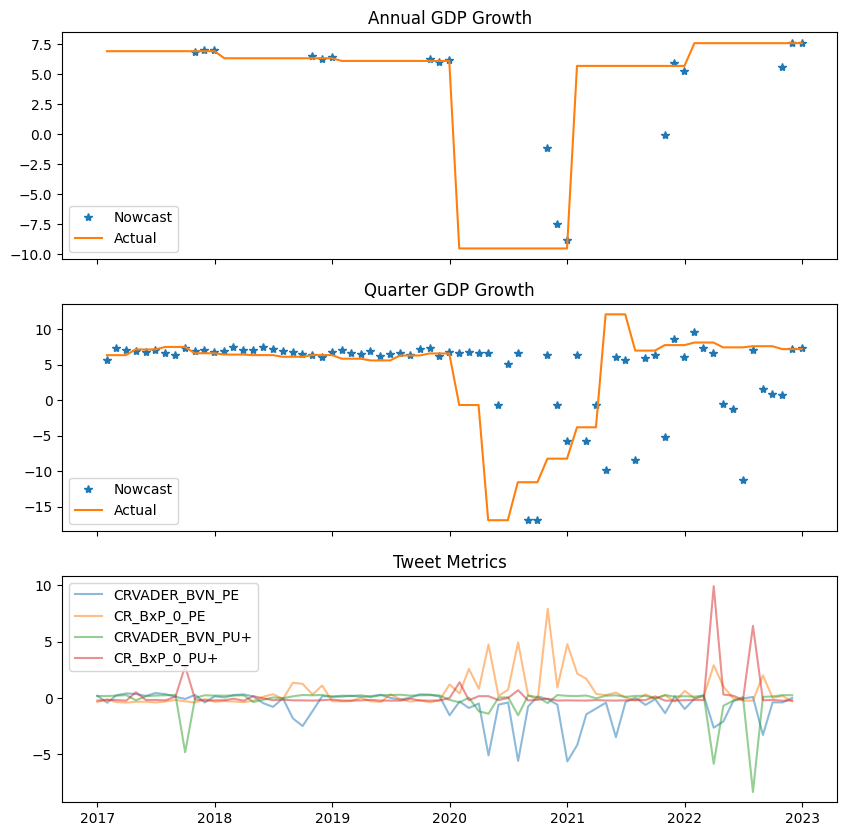

In [6]:
target = 'GDP'
# kmpair = {}
kmpair = {'PE': ['CRVADER_BVN','CR_BxP_0'],'PU+': ['CRVADER_BVN','CR_BxP_0']}
window = 1000
model = NowcastingXGBoost(lag_order=(0,1,0), kmpair=kmpair, target=target) # lag_order = target_lag, tweet_lag, econ_lag
summary = model.run(window=window,save_aggregate=True, with_econ=False, with_tweets=True, multiprocess=processes)
tweets = model.load_tweets('2023-01-01', kmpair=kmpair, window=window+72).loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(summary['date'], summary['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(summary['date'], summary['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(summary['date'], summary['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(summary['date'], summary['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_title('Tweet Metrics')
fig.show()
summary